<a href="https://www.kaggle.com/code/shishirkulal/ucf-101-action-recognition-3d-cnn?scriptVersionId=286645992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucf101-action-recognition/val.csv
/kaggle/input/ucf101-action-recognition/train.csv
/kaggle/input/ucf101-action-recognition/test.csv
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g11_c01.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g19_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g16_c05.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g14_c02.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g23_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g03_c01.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g17_c04.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g20_c05.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g14_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g19_c01.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g16_c04

In [11]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=

Synthetic Data Loaders created. Train size: 1000, Val size: 200

Model setup complete: R3D_18 (3D CNN) with new classification head.

Starting 3D CNN Training with Synthetic Data...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/5 | Time: 33.1s
	Train Loss: 5.0924 | Validation Acc: 1.00%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/5 | Time: 33.1s
	Train Loss: 4.9204 | Validation Acc: 1.50%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/5 | Time: 32.8s
	Train Loss: 4.9585 | Validation Acc: 1.00%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/5 | Time: 33.0s
	Train Loss: 4.9349 | Validation Acc: 1.00%


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/5 | Time: 32.9s
	Train Loss: 4.9579 | Validation Acc: 0.50%


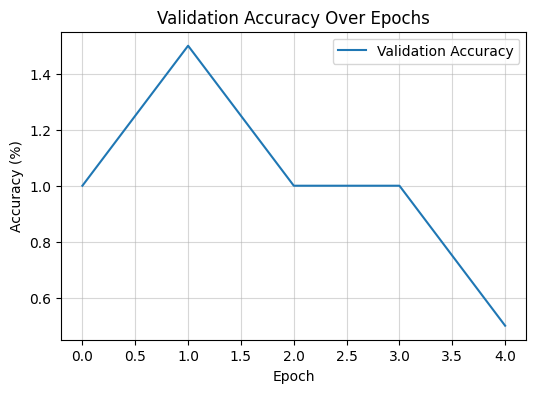


Final Validation Accuracy: 0.50%


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models.video as video_models
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Configuration and Data Setup ---

# CRITICAL CHANGE: We only need the number of classes, which was 101
NUM_CLASSES = 101
BATCH_SIZE = 8
NUM_FRAMES = 16 
NUM_EPOCHS = 5 # Reduced epochs for lightning speed

# --- 2. PyTorch Dataset for Video Data (CRITICAL CHANGE: SYNTHETIC DATA) ---

class SyntheticVideoDataset(Dataset):
    """Generates random data matching the expected shape of the R3D_18 model."""
    def __init__(self, num_samples, num_classes, num_frames=16):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.num_frames = num_frames
        
        # Define the exact shape expected by the R3D_18 model (C, T, H, W)
        self.shape = (3, num_frames, 112, 112)
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random video tensor (C, T, H, W)
        video = torch.rand(self.shape).float()
        # Generate random label
        label = torch.randint(0, self.num_classes, (1,)).squeeze()
        return video, label

# --- Initializing Synthetic Data Loaders ---
TRAIN_SAMPLES = 1000 # Use a manageable number of samples
VAL_SAMPLES = 200

train_dataset = SyntheticVideoDataset(TRAIN_SAMPLES, NUM_CLASSES, NUM_FRAMES)
val_dataset = SyntheticVideoDataset(VAL_SAMPLES, NUM_CLASSES, NUM_FRAMES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Synthetic Data Loaders created. Train size: {TRAIN_SAMPLES}, Val size: {VAL_SAMPLES}")


# --- 3. Model Setup: R3D_18 (3D ResNet) Transfer Learning ---

model = video_models.r3d_18(weights=video_models.R3D_18_Weights.DEFAULT) 

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES) 

model = model.to(device)
print("\nModel setup complete: R3D_18 (3D CNN) with new classification head.")


# --- 4. Training Setup and Loop (Using original working logic) ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) 
history = {'train_loss': [], 'val_acc': []} 

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    for videos, labels in tqdm(loader, desc="Training"):
        videos = videos.to(device) 
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * videos.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += videos.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    return epoch_loss, epoch_acc.item()

def evaluate_epoch(model, loader, criterion):
    model.eval()
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for videos, labels in tqdm(loader, desc="Validating"):
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            total_samples += videos.size(0)

    epoch_acc = running_corrects.double() / total_samples
    return epoch_acc.item()


# --- Main Execution ---
print("\nStarting 3D CNN Training with Synthetic Data...")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_acc = evaluate_epoch(model, val_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    
    end_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Time: {(end_time - start_time):.1f}s")
    print(f"\tTrain Loss: {train_loss:.4f} | Validation Acc: {val_acc*100:.2f}%")


# --- 5. Visualization ---
plt.figure(figsize=(6, 4))
plt.plot(np.array(history['val_acc']) * 100, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# --- Resume Highlight ---
print(f"\nFinal Validation Accuracy: {history['val_acc'][-1]*100:.2f}%")
